#Importar

In [ ]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy.integrate import odeint
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
#from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Tratamiento del dataset para entrenar el modelo random forest

In [ ]:
#El dataset shopping_behavior_updated fue descargado de Kaggle, en otro documento verifique que no necesita imputaciones y que está equilibrado.
#De todas las características que contiene el dataset solo voy a conservar Age, Gender (que lo cambie por Femenino para binarizarlo), Review,
#Size, Category, y Item Purchased. El dataset contiene información de lo consumidores y artículos de vestir que compraron. Además, eliminé las filas
#que contenian algunos artículos para facilitar la modelización de trueques. Tal como se constata más adelante, se usan algunas características de los
#consumidores como su edad, genero, etc., para predecir el artículo que quieren comprar. En el caso de los trueques esta información se usa para
#identificar los usuarios que tienen intenciones de adquirir el mismo producto, ya que a estos ingresaran a una interacción mutualista que determinará
#quién será la persona que en efecto adquiriá el producto.
df = pd.read_csv('/content/shopping_behavior_updated.csv')
columnas_a_eliminar = ['Color','Customer ID', 'Purchase Amount (USD)', 'Season', 'Subscription Status', 'Shipping Type', 'Discount Applied', 'Promo Code Used', 'Previous Purchases', 'Payment Method', 'Frequency of Purchases', 'Location']
df = df.drop(columns=columnas_a_eliminar)
df = pd.get_dummies(df, columns=['Size', 'Category'])
df['Age'] = df['Age']>df['Age'].median()
df['Review Rating'] = df['Review Rating']>df['Review Rating'].median()
df.rename(columns={'Gender': 'Femenino'}, inplace=True)
df['Femenino'] = df['Femenino'].replace({'Female': 1, 'Male': 0})
df.drop('Category_Outerwear', axis=1, inplace=True)

df = df[~df['Item Purchased'].str.contains('Jewelry') & ~df['Item Purchased'].str.contains('Shirt')& ~df['Item Purchased'].str.contains('Blouse')
& ~df['Item Purchased'].str.contains('Sweater')& ~df['Item Purchased'].str.contains('Socks')& ~df['Item Purchased'].str.contains('Sandals')
& ~df['Item Purchased'].str.contains('Sunglasses')& ~df['Item Purchased'].str.contains('Coat')& ~df['Item Purchased'].str.contains('Jacket')
& ~df['Item Purchased'].str.contains('Skirt')& ~df['Item Purchased'].str.contains('Shorts')& ~df['Item Purchased'].str.contains('Scarf')
& ~df['Item Purchased'].str.contains('Handbag')& ~df['Item Purchased'].str.contains('Hoodie')
& ~df['Item Purchased'].str.contains('Shoes')& ~df['Item Purchased'].str.contains('T-shirt')
& ~df['Item Purchased'].str.contains('Backpack')& ~df['Item Purchased'].str.contains('Gloves')& ~df['Item Purchased'].str.contains('Jeans')
& ~df['Item Purchased'].str.contains('Hat')]

mapeo_itempur = {'Pants': 1, 'Dress': 2, 'Belt': 3, 'Sneakers':4, 'Boots':5}
# Aplicar el reemplazo en la columna "Category"
df['Item Purchased'] = df['Item Purchased'].replace(mapeo_itempur)


#Modelo Random Forest

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

X = df.drop('Item Purchased', axis=1)
y = df['Item Purchased']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializando el modelo de Random Forest
rf=RandomForestClassifier(criterion="gini",n_estimators=10,min_samples_split=4, min_samples_leaf=2)

# Entrenando el modelo
rf.fit(X_train, y_train)



RandomForestClassifier(min_samples_leaf=2, min_samples_split=4, n_estimators=10)

#Función con ecuaciones Lotka-Volterra para el caso mutualista


In [ ]:
# Lotka Volterra mutualismo
def sim(variables, t, params):

      x = variables[0]
      y = variables[1]
      r1 = params[0]
      r2 = params[1]
      alpha = params[2]
      beta = params[3]
      delta = params[4]
      gamma = params[5]

      dxdt = r1*x*(1 - alpha*x + beta* y)
      dydt = r2*y*(1 + delta*x - gamma*y)

      return([dxdt, dydt])

#Generación de Matriz de características: Edad, Sexo, y Calificación de satisfacción en los trueques

In [ ]:
#Aquí consideré a la característica "Review" como la valoración del trueque realizado
F = np.random.randint(0, 2, size=(24, 3))

#Función Trueque Mutualista

In [ ]:
def tru_mut(Pi):
    P = Pi.copy()
    M = []
    t = np.arange(0, 201, 1)
    n = len(P)
    #Estoy usando el criterio de la varianza de la capacidad de trueque de las 24 personas dispuestas a truequiar para regular el monopolio de dicha capacidad
    #de manera que si la varianza disminuye considero que existe menos acumulación de dicha capacidad en manos de pocos.
    varP = np.zeros(len(t))
    #Estos parámetros los encontré en la literatura de interacciones mutualistas
    params = [0.01, 0.01, 0.2, 0.1, 0.1, 0.2]
    # El siguiente código hace las transacciones a lo largo del tiempo de manera que cada vez que una persona gana 1 bien o servicio
    # otra pierde un bien o servicio los intercambios son regulados por las preferencias de productos a truequiar y por la interacción mutualista
    for step in range(len(t)):
        varP[step] = np.var(P)
        #matrpref establece en cada unidad de tiempo la matriz de características de los usuarios adicionando a la matriz F (que contiene la
        #la información de la edad, sexo, y calificación) la categoría de producto que quiere adquirir, y su tamaño--estas características
        #cambian en cada unidad de tiempo
        matrpref = np.empty((0, 10), dtype=int)
        G = np.random.randint(0, 2, size=(24, 7))
        tn = np.arange(0, (step+1), 1)
        for fila_F, fila_G in zip(F, G):
            nueva_fila = np.concatenate((fila_F, fila_G))
            matrpref = np.vstack((matrpref, nueva_fila))
        #Aquí uso el modelo random forest ya entrenado para obtener las preferencias de intercambio de las 24 personas involucradas
        pred=rf.predict(matrpref)
        p=np.array(pred)
        #Los arreglos I, II, III, IV y V contienen las personas (nombradas del 1 al 24) que quieren intercambiar el producto 1 (pantalones),
        #2 (vestidos), 3 (correas), 4 (zapatos deportivos), o 5 (botas) respectivamente
        I = []
        II = []
        III = []
        IV = []
        V = []
        for j in range(24):
            if p[j]==1:
              I.append(j)
            if p[j]==2:
              II.append(j)
            if p[j]==3:
              III.append(j)
            if p[j]==4:
              IV.append(j)
            if p[j]==5:
              V.append(j)
        I=np.array(I)
        n1=len(I)
        #Aquí se toma una persona al azar que entregará el producto 1 y entre un par de personas interesadas en recibir dicho producto se decidirá
        #quién en efecto lo recibirá de acuerdo a la interacción mutualista
        if n1>1:
          i11 = random.randint(0, n1-1)
          i12 = random.randint(0, n1-1)
          i1q = random.randint(0, n-1)
          P[i1q] -= 1
          y01 = [Pi[I[i11]], Pi[I[i12]]]
          result1 = odeint(sim, y01, tn, args=(params,))
          R1 = result1[-1, :]
          dxdt1, dydt1 = sim(R1, tn, params)
          # Al comparar las derivadas se decide darle un bien o servicio al que tenga el valor mayor de derivada
          if dxdt1 > dydt1:
              P[I[i11]] += 1
          else:
              P[I[i12]] += 1
          #M.append(P.copy())
        else:
         continue

        #Aquí se toma una persona al azar que entregará el producto 2 y entre un par de personas interesadas en recibir dicho producto se decidirá
        #quién en efecto lo recibirá de acuerdo a la interacción mutualista
        II=np.array(II)
        n2=len(II)
        if n2>1:
          i21 = random.randint(0, n1-1)
          i22 = random.randint(0, n1-1)
          i2q = random.randint(0, n-1)
          P[i2q] -= 1
          y02 = [Pi[I[i21]], Pi[I[i22]]]
          result2 = odeint(sim, y02, tn, args=(params,))
          R2 = result2[-1, :]
          dxdt2, dydt2 = sim(R2, tn, params)
          if dxdt2 > dydt2:
              P[I[i21]] += 1
          else:
              P[I[i22]] += 1
          #M.append(P.copy())
        else:
          continue

        #Aquí se toma una persona al azar que entregará el producto 3 y entre un par de personas interesadas en recibir dicho producto se decidirá
        #quién en efecto lo recibirá de acuerdo a la interacción mutualista
        III=np.array(III)
        n3=len(III)
        if n3>1:
          i31 = random.randint(0, n1-1)
          i32 = random.randint(0, n1-1)
          i3q = random.randint(0, n-1)
          P[i3q] -= 1
          y03 = [Pi[I[i31]], Pi[I[i32]]]
          result3 = odeint(sim, y03, tn, args=(params,))
          R3 = result3[-1, :]
          dxdt3, dydt3 = sim(R3, tn, params)
          if dxdt3 > dydt3:
              P[I[i31]] += 1
          else:
              P[I[i32]] += 1
          #M.append(P.copy())
        else:
          continue

        #Aquí se toma una persona al azar que entregará el producto 4 y entre un par de personas interesadas en recibir dicho producto se decidirá
        #quién en efecto lo recibirá de acuerdo a la interacción mutualista
        IV=np.array(IV)
        n4=len(IV)
        if n4>1:
          i41 = random.randint(0, n1-1)
          i42 = random.randint(0, n1-1)
          i4q = random.randint(0, n-1)
          P[i4q] -= 1
          y04 = [Pi[I[i41]], Pi[I[i42]]]
          result4 = odeint(sim, y04, tn, args=(params,))
          R4 = result4[-1, :]
          dxdt4, dydt4 = sim(R4, tn, params)
          if dxdt4 > dydt4:
              P[I[i41]] += 1
          else:
              P[I[i42]] += 1
          #M.append(P.copy())
        else:
          continue

        #Aquí se toma una persona al azar que entregará el producto 5 y entre un par de personas interesadas en recibir dicho producto se decidirá
        #quién en efecto lo recibirá de acuerdo a la interacción mutualista
        V=np.array(V)
        n5=len(V)
        if n5>1:
          i51 = random.randint(0, n1-1)
          i52 = random.randint(0, n1-1)
          i5q = random.randint(0, n-1)
          P[i5q] -= 1
          y05 = [Pi[I[i51]], Pi[I[i52]]]
          result5 = odeint(sim, y05, tn, args=(params,))
          R5 = result5[-1, :]
          dxdt5, dydt5 = sim(R5, tn, params)
          if dxdt5 > dydt5:
              P[I[i51]] += 1
          else:
              P[I[i52]] += 1
          #M.append(P.copy())
        else:
          continue
        M.append(P.copy())
    return(varP, M)


#Función Trueque Mutualista cambio de predicciones a diario

In [ ]:
def tru_mutd(Pi):
    P = Pi.copy()
    M = []
    t = np.arange(0, 241, 1)
    n = len(P)
    #Estoy usando el criterio de la varianza de la capacidad de trueque de las 24 personas dispuestas a truequiar para regular el monopolio de dicha capacidad
    #de manera que si la varianza disminuye considero que existe menos acumulación de dicha capacidad en manos de pocos.
    varP = np.zeros(len(t))
    #Estos parámetros los encontré en la literatura de interacciones mutualistas
    params = [0.01, 0.01, 0.2, 0.1, 0.1, 0.2]
    # El siguiente código hace las transacciones a lo largo del tiempo de manera que cada vez que una persona gana 1 bien o servicio
    # otra pierde un bien o servicio los intercambios son regulados por las preferencias de productos a truequiar y por la interacción mutualista
    for step in range(len(t)):
        varP[step] = np.var(P)
        tn = np.arange(0, (step+1), 1)
        #matrpref establece en cada unidad de tiempo la matriz de características de los usuarios adicionando a la matriz F (que contiene la
        #la información de la edad, sexo, y calificación) la categoría de producto que quiere adquirir, y su tamaño--estas características
        #cambian en cada unidad de tiempo
        if step % 24 == 0 or step == 0:
           matrpref = np.empty((0, 10), dtype=int)
           G = np.random.randint(0, 2, size=(24, 7))
           for fila_F, fila_G in zip(F, G):
              nueva_fila = np.concatenate((fila_F, fila_G))
              matrpref = np.vstack((matrpref, nueva_fila))
        #Aquí uso el modelo random forest ya entrenado para obtener las preferencias de intercambio de las 24 personas involucradas
        pred=rf.predict(matrpref)
        p=np.array(pred)
        #Los arreglos I, II, III, IV y V contienen las personas (nombradas del 1 al 24) que quieren intercambiar el producto 1 (pantalones),
        #2 (vestidos), 3 (correas), 4 (zapatos deportivos), o 5 (botas) respectivamente
        I = []
        II = []
        III = []
        IV = []
        V = []
        for j in range(24):
            if p[j]==1:
              I.append(j)
            if p[j]==2:
              II.append(j)
            if p[j]==3:
              III.append(j)
            if p[j]==4:
              IV.append(j)
            if p[j]==5:
              V.append(j)
        I=np.array(I)
        n1=len(I)
        #Aquí se toma una persona al azar que entregará el producto 1 y entre un par de personas interesadas en recibir dicho producto se decidirá
        #quién en efecto lo recibirá de acuerdo a la interacción mutualista
        if n1>1:
          i11 = random.randint(0, n1-1)
          i12 = random.randint(0, n1-1)
          i1q = random.randint(0, n-1)
          P[i1q] -= 1
          y01 = [Pi[I[i11]], Pi[I[i12]]]
          result1 = odeint(sim, y01, tn, args=(params,))
          R1 = result1[-1, :]
          dxdt1, dydt1 = sim(R1, tn, params)
          # Al comparar las derivadas se decide darle un bien o servicio al que tenga el valor mayor de derivada
          if dxdt1 > dydt1:
              P[I[i11]] += 1
          else:
              P[I[i12]] += 1
          #M.append(P.copy())
        else:
         continue

        #Aquí se toma una persona al azar que entregará el producto 2 y entre un par de personas interesadas en recibir dicho producto se decidirá
        #quién en efecto lo recibirá de acuerdo a la interacción mutualista
        II=np.array(II)
        n2=len(II)
        if n2>1:
          i21 = random.randint(0, n1-1)
          i22 = random.randint(0, n1-1)
          i2q = random.randint(0, n-1)
          P[i2q] -= 1
          y02 = [Pi[I[i21]], Pi[I[i22]]]
          result2 = odeint(sim, y02, tn, args=(params,))
          R2 = result2[-1, :]
          dxdt2, dydt2 = sim(R2, tn, params)
          if dxdt2 > dydt2:
              P[I[i21]] += 1
          else:
              P[I[i22]] += 1
          #M.append(P.copy())
        else:
          continue

        #Aquí se toma una persona al azar que entregará el producto 3 y entre un par de personas interesadas en recibir dicho producto se decidirá
        #quién en efecto lo recibirá de acuerdo a la interacción mutualista
        III=np.array(III)
        n3=len(III)
        if n3>1:
          i31 = random.randint(0, n1-1)
          i32 = random.randint(0, n1-1)
          i3q = random.randint(0, n-1)
          P[i3q] -= 1
          y03 = [Pi[I[i31]], Pi[I[i32]]]
          result3 = odeint(sim, y03, tn, args=(params,))
          R3 = result3[-1, :]
          dxdt3, dydt3 = sim(R3, tn, params)
          if dxdt3 > dydt3:
              P[I[i31]] += 1
          else:
              P[I[i32]] += 1
          #M.append(P.copy())
        else:
          continue

        #Aquí se toma una persona al azar que entregará el producto 4 y entre un par de personas interesadas en recibir dicho producto se decidirá
        #quién en efecto lo recibirá de acuerdo a la interacción mutualista
        IV=np.array(IV)
        n4=len(IV)
        if n4>1:
          i41 = random.randint(0, n1-1)
          i42 = random.randint(0, n1-1)
          i4q = random.randint(0, n-1)
          P[i4q] -= 1
          y04 = [Pi[I[i41]], Pi[I[i42]]]
          result4 = odeint(sim, y04, tn, args=(params,))
          R4 = result4[-1, :]
          dxdt4, dydt4 = sim(R4, tn, params)
          if dxdt4 > dydt4:
              P[I[i41]] += 1
          else:
              P[I[i42]] += 1
          #M.append(P.copy())
        else:
          continue

        #Aquí se toma una persona al azar que entregará el producto 5 y entre un par de personas interesadas en recibir dicho producto se decidirá
        #quién en efecto lo recibirá de acuerdo a la interacción mutualista
        V=np.array(V)
        n5=len(V)
        if n5>1:
          i51 = random.randint(0, n1-1)
          i52 = random.randint(0, n1-1)
          i5q = random.randint(0, n-1)
          P[i5q] -= 1
          y05 = [Pi[I[i51]], Pi[I[i52]]]
          result5 = odeint(sim, y05, tn, args=(params,))
          R5 = result5[-1, :]
          dxdt5, dydt5 = sim(R5, tn, params)
          if dxdt5 > dydt5:
              P[I[i51]] += 1
          else:
              P[I[i52]] += 1
          #M.append(P.copy())
        else:
          continue
        M.append(P.copy())
    return(varP, M)


#Generador de una matriz de capacidad de trueques en el tiempo

In [131]:
#T es un arreglo que asigna aleatoreamente la capacidad de trueque con un máximo de 50 (i.e. 50 bienes o servicios que una persona puede truequiar)
T=np.random.randint(1, 51, size=24)
#Matriz_trueques registra la capacidad de trueque de cada persona a lo largo de las 200 unidades de tiempo
Matriz_trueques=tru_mut(T)[1]
Varianza=tru_mut(T)[0]
Matriz_trueques

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X

[array([36,  7, 30,  5, 50, 25,  2,  8, 31, 22, 36, 39, 43, 39,  3, 44, 27,
        23,  8, 12, 50,  4, 49, 25]),
 array([36,  7, 31,  5, 50, 24,  2,  8, 31, 22, 35, 39, 43, 39,  3, 44, 27,
        26,  8, 12, 50,  3, 49, 24]),
 array([37,  8, 29,  5, 47, 23,  0,  8, 31, 23, 34, 39, 43, 39,  6, 44, 25,
        25,  8, 12, 50,  6, 51, 25]),
 array([37,  5, 29,  5, 46, 23,  0,  8, 31, 23, 33, 39, 42, 39,  6, 44, 27,
        25,  8, 12, 50,  5, 51, 30]),
 array([37,  5, 30,  6, 46, 23, -1,  7, 31, 23, 33, 42, 42, 39,  6, 44, 26,
        24,  8, 14, 50,  5, 50, 28]),
 array([37,  3, 30,  9, 46, 23,  1,  6, 30, 23, 33, 42, 42, 38,  9, 44, 25,
        23,  8, 13, 49,  5, 50, 29]),
 array([36,  2, 33,  9, 45, 21,  3,  5, 30, 20, 32, 42, 42, 37,  8, 43, 26,
        25,  8, 13, 49,  7, 50, 32]),
 array([37,  2, 33,  9, 45, 20,  2,  5, 30, 20, 32, 42, 42, 37,  8, 42, 25,
        25,  8, 13, 49,  7, 50, 35]),
 array([37,  2, 32, 11, 44, 19,  2,  5, 30, 20, 31, 42, 42, 36,  8, 42, 24,
        24, 

In [132]:
#Td es un arreglo que asigna aleatoreamente la capacidad de trueque con un máximo de 50 (i.e. 50 bienes o servicios que una persona puede truequiar)
#Td=T.copy
#Matriz_trueques diarios registra la capacidad de trueque de cada persona a lo largo de las 240 horas
Matriz_truequesd=tru_mutd(T)[1]
Varianzad=tru_mutd(T)[0]
Matriz_truequesd

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X

[array([36,  6, 28,  8, 48, 24,  2,  8, 31, 22, 36, 42, 43, 40,  4, 45, 24,
        24,  8, 12, 50,  3, 49, 25]),
 array([36,  6, 28, 12, 48, 24,  2,  7, 31, 21, 35, 43, 43, 40,  4, 45, 24,
        24,  8, 12, 50,  2, 48, 25]),
 array([36,  6, 27, 16, 48, 24,  2,  6, 31, 21, 35, 44, 43, 40,  4, 44, 24,
        24,  8, 11, 50,  2, 48, 24]),
 array([35,  6, 27, 20, 47, 24,  2,  5, 30, 21, 35, 45, 43, 40,  4, 44, 23,
        24,  8, 11, 50,  2, 48, 24]),
 array([34,  6, 27, 24, 47, 24,  2,  5, 29, 21, 33, 46, 43, 40,  4, 44, 23,
        23,  8, 11, 50,  2, 48, 24]),
 array([34,  6, 27, 28, 46, 24,  2,  4, 29, 21, 33, 46, 43, 39,  4, 44, 23,
        23,  8, 11, 50,  2, 48, 23]),
 array([34,  6, 27, 30, 46, 24,  2,  4, 28, 21, 33, 48, 43, 39,  4, 44, 23,
        23,  7, 11, 50,  2, 47, 22]),
 array([34,  4, 27, 34, 46, 23,  2,  4, 28, 21, 33, 49, 42, 39,  3, 44, 23,
        23,  7, 11, 50,  2, 47, 22]),
 array([34,  4, 27, 39, 46, 23,  2,  3, 28, 21, 33, 49, 42, 38,  3, 44, 23,
        23, 

#Varianza

In [133]:
Varianza

array([259.9375    , 257.1875    , 257.1875    , 245.52083333,
       245.6875    , 241.1875    , 239.10416667, 239.10416667,
       225.10416667, 225.10416667, 219.52083333, 219.52083333,
       216.77083333, 216.77083333, 207.77083333, 203.02083333,
       201.35416667, 200.4375    , 200.85416667, 195.10416667,
       193.27083333, 200.35416667, 206.10416667, 207.6875    ,
       205.1875    , 206.9375    , 206.9375    , 200.6875    ,
       192.77083333, 193.77083333, 199.02083333, 201.4375    ,
       202.52083333, 208.4375    , 213.35416667, 212.4375    ,
       211.02083333, 209.52083333, 211.27083333, 209.1875    ,
       202.02083333, 208.35416667, 208.35416667, 209.85416667,
       209.85416667, 204.77083333, 205.35416667, 203.1875    ,
       196.35416667, 199.6875    , 199.6875    , 197.77083333,
       208.60416667, 208.60416667, 212.52083333, 212.52083333,
       204.9375    , 208.9375    , 207.85416667, 207.85416667,
       212.85416667, 215.60416667, 215.60416667, 215.60

In [134]:
Varianzad

array([259.9375    , 255.6875    , 249.9375    , 246.02083333,
       242.77083333, 237.85416667, 241.1875    , 240.35416667,
       241.60416667, 244.9375    , 247.27083333, 252.60416667,
       250.27083333, 251.77083333, 248.27083333, 250.60416667,
       252.10416667, 255.6875    , 259.27083333, 266.4375    ,
       270.6875    , 272.10416667, 278.02083333, 280.10416667,
       285.85416667, 285.85416667, 285.85416667, 285.85416667,
       285.85416667, 285.85416667, 285.85416667, 285.85416667,
       285.85416667, 285.85416667, 285.85416667, 285.85416667,
       285.85416667, 285.85416667, 285.85416667, 285.85416667,
       285.85416667, 285.85416667, 285.85416667, 285.85416667,
       285.85416667, 285.85416667, 285.85416667, 285.85416667,
       285.85416667, 282.02083333, 285.60416667, 282.02083333,
       283.9375    , 284.02083333, 282.6875    , 286.27083333,
       287.77083333, 285.77083333, 282.35416667, 279.02083333,
       277.9375    , 281.27083333, 284.77083333, 283.77

#Gráfica de evolución de la varianza

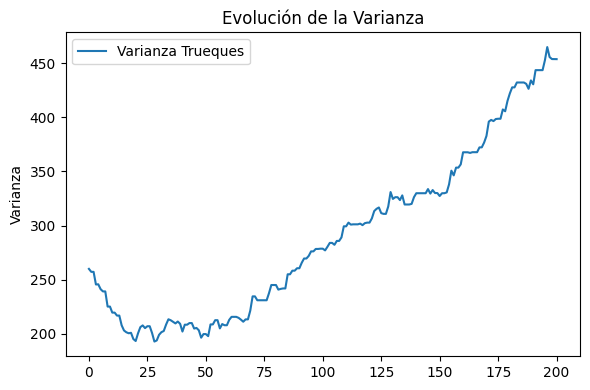

In [135]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4), sharex=True)
t = np.arange(0, 201, 1)
axs.plot(t, Varianza, label='Varianza Trueques')
axs.set_ylabel('Varianza')
axs.set_title('Evolución de la Varianza')
axs.legend()

plt.tight_layout()
plt.show()

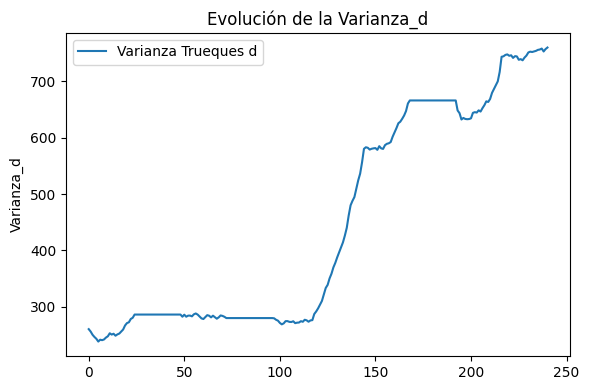

In [136]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4), sharex=True)
t = np.arange(0, 241, 1)
axs.plot(t, Varianzad, label='Varianza Trueques d')
axs.set_ylabel('Varianza_d')
axs.set_title('Evolución de la Varianza_d')
axs.legend()

plt.tight_layout()
plt.show()

#Tiempo en adquirir un bien o servicio

In [137]:
indopt=np.argmin(Varianza)
matrmin=Matriz_trueques[:indopt]
matrcont=[]
for step in range(len(matrmin) - 1):
    matrcont.append(matrmin[step+1]-matrmin[step])
Mcont=np.array(matrcont)
indopt

28

In [138]:
indoptd=np.argmin(Varianzad)
matrmind=Matriz_truequesd[:indoptd]
matrcontd=[]
for step in range(len(matrmind)-1):
    matrcontd.append(matrmind[step+1]-matrmind[step])
Mcontd=np.array(matrcontd)
indoptd

5

In [139]:
def contar(matriz):
  N=matriz.shape[0]
  d=[]
  for j in range(24):
    r=0
    c=[0]
    tesp=[]

    for i in range(N):
      if matriz[i,j] ==1:
         c.append(i+1)
    if matriz[N-1,j] !=1:
      c.append(N+1)
    Nn=len(c)
    for t in range(Nn-1):
      tesp.append(c[t+1]-c[t]-1)
    a=sum(tesp)/len(tesp)
    d.append(a)
  prom=sum(d)/len(d)
  prom

  return(d,prom)

In [140]:
def contun(matriz):
 #s1=0
 #sno1=0
 S1=[]
 Sno1=[]
 N=matriz.shape[0]
 for j in range(24):
    s1=0
    sno1=0
    for i in range(N):
      if matriz[i,j]>0:
         s1=s1+matriz[i,j]
      else:
         sno1=sno1+matriz[i,j]
    S1.append(s1)
    Sno1.append(sno1)

 return(S1,Sno1)


In [141]:
#El arreglo diferencias muestra la diferencia de bienes y servicios que cada persona da menos los que recibe por cada ciclo
Aum=np.array(contun(Mcont)[0])
Dism=np.array(contun(Mcont)[1])
Dis=np.abs(Dism)
ryd=np.vstack([Aum,Dis])
diferencias = ryd[0] - ryd[1]
diferencias



array([  2,  -5,   0,   6, -16,  -9,  28, -10,  -9,   8,   1,   5,  -8,
       -13,  -1,  -5,   5,  14,  -4,   5,  -7,   0,  -2,  15])

In [142]:
# La variavle recmasqdar indica cuantas personas recibieron mas bienes y servicios de los que ofrecieron en un ciclo
recmasqdar = np.count_nonzero(diferencias >= 0)
recmasqdar

12

In [143]:
# El dataframe RyD muestra cuantos bienes o servicios se recibieron (en la primera fila) y cuantos se dieron (en la segunda fila)
# por cada persona en cada ciclo
rydt=np.transpose(ryd)
RyD=pd.DataFrame(rydt, index=['Persona 1', 'Persona 2', 'Persona 3','Persona 4', 'Persona 5', 'Persona 6',
                                                         'Persona 7', 'Persona 8', 'Persona 9','Persona 10', 'Persona 11', 'Persona 12',
                                                         'Persona 13', 'Persona 14', 'Persona 15','Persona 16', 'Persona 17', 'Persona 18',
                                                         'Persona 19', 'Persona 20', 'Persona 21','Persona 22', 'Persona 23', 'Persona 24'], columns=['Reciben', 'Dan'], )
RyD

,Reciben,Dan
Persona 1,8,6
Persona 2,6,11
Persona 3,7,7
Persona 4,13,7
Persona 5,0,16
Persona 6,0,9
Persona 7,33,5
Persona 8,0,10
Persona 9,2,11
Persona 10,18,10


In [144]:
tr=contar(Mcont)[0]
ni=len(tr)
for i in range(ni):
   if tr[i]==0:
      tr[i]=0.1
tr

[8.333333333333334,
 8.333333333333334,
 8.333333333333334,
 8.333333333333334,
 27.0,
 27.0,
 13.0,
 27.0,
 27.0,
 3.6666666666666665,
 27.0,
 13.0,
 27.0,
 27.0,
 6.0,
 6.0,
 8.333333333333334,
 13.0,
 13.0,
 13.0,
 27.0,
 27.0,
 13.0,
 4.6]

In [145]:
trd=contar(Mcontd)[0]
nid=len(trd)
for i in range(nid):
   if trd[i]==0:
      trd[i]=0.1
trd

[4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 0.1,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0]

Text(0, 0.5, 'Tiempo Recibir')

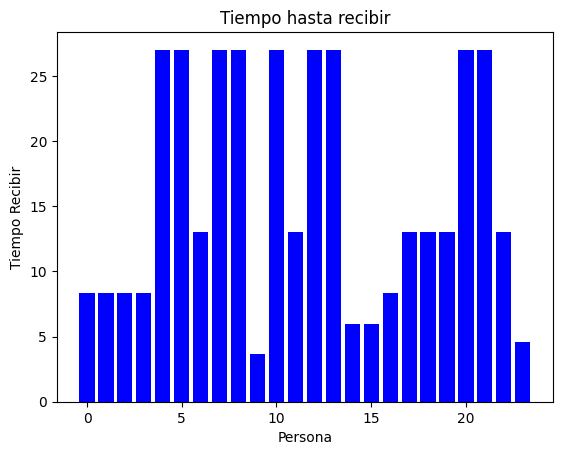

In [146]:
indices = np.arange(len(tr))
plt.bar(indices, tr, color='blue')
plt.title('Tiempo hasta recibir')
plt.xlabel('Persona')
plt.ylabel('Tiempo Recibir')

Text(0, 0.5, 'Tiempo Recibir_d')

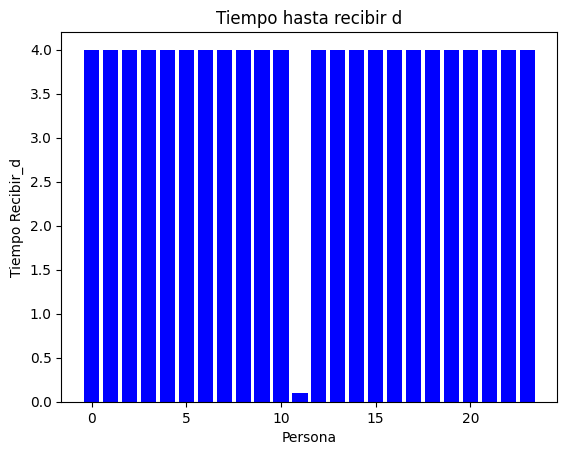

In [147]:
indices = np.arange(len(trd))
plt.bar(indices, trd, color='blue')
plt.title('Tiempo hasta recibir d')
plt.xlabel('Persona')
plt.ylabel('Tiempo Recibir_d')

In [148]:
contar(Mcont)[1]

15.955555555555556

In [149]:
contar(Mcontd)[1]

3.8333333333333335

#Tiempo promedio en brindar un bien o servicio

In [ ]:
def contar2(matriz):
  N=matriz.shape[0]
  d=[]
  for j in range(24):
    r=0
    c=[0]
    tesp=[]

    for i in range(N):
      if matriz[i,j] ==-1:
         c.append(i+1)
    if matriz[N-1,j] !=-1:
      c.append(N+1)
    Nn=len(c)
    for t in range(Nn-1):
      tesp.append(c[t+1]-c[t]-1)
    a=sum(tesp)/len(tesp)
    d.append(a)
  prom2=sum(d)/len(d)


  return(d, prom2)

In [ ]:
tof=contar2(Mcont)[0]
nio=len(tof)
for i in range(nio):
   if tof[i]==0:
      tof[i]=0.1
tof

[9.5,
 2.727272727272727,
 4.125,
 4.125,
 5.0,
 1.2777777777777777,
 7.4,
 2.727272727272727,
 1.8,
 7.4,
 6.0,
 4.125,
 4.25,
 2.230769230769231,
 4.125,
 3.6666666666666665,
 3.2,
 3.5555555555555554,
 2.230769230769231,
 3.1,
 5.0,
 4.25,
 3.6666666666666665,
 6.0]

In [ ]:
tofd=contar2(Mcontd)[0]
niod=len(tofd)
for i in range(niod):
   if tofd[i]==0:
      tofd[i]=0.1
tofd


[2.6666666666666665,
 21.0,
 3.4,
 3.4,
 3.4,
 4.5,
 3.4,
 4.5,
 4.5,
 2.6666666666666665,
 4.25,
 2.6666666666666665,
 4.5,
 3.2,
 2.0,
 4.5,
 6.0,
 6.333333333333333,
 6.333333333333333,
 10.0,
 21.0,
 4.5,
 4.25,
 2.142857142857143]

Text(0, 0.5, 'Tiempo hasta dar')

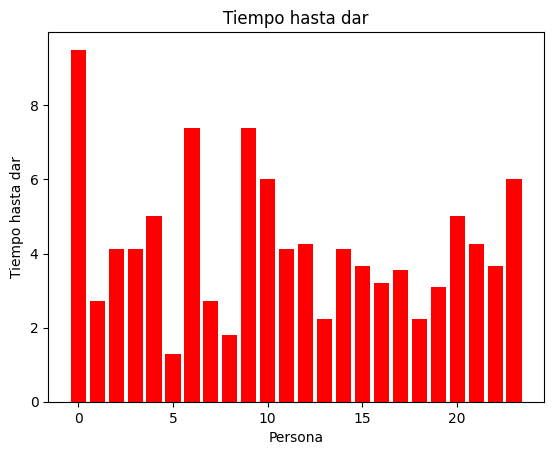

In [ ]:
indices = np.arange(len(tof))
plt.bar(indices, tof, color='red')
plt.title('Tiempo hasta dar')
plt.xlabel('Persona')
plt.ylabel('Tiempo hasta dar')

Text(0, 0.5, 'Tiempo hasta dar_d')

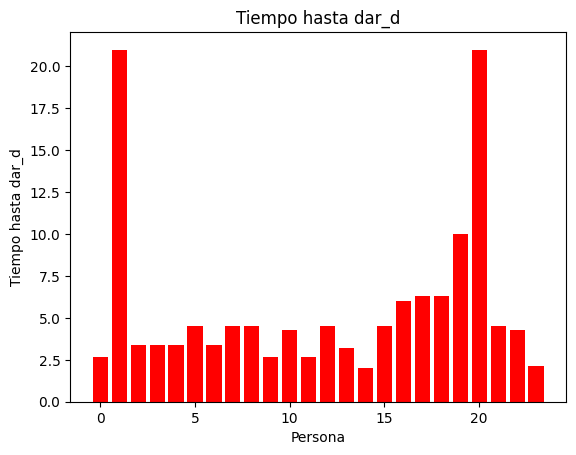

In [ ]:
indices = np.arange(len(tofd))
plt.bar(indices, tofd, color='red')
plt.title('Tiempo hasta dar_d')
plt.xlabel('Persona')
plt.ylabel('Tiempo hasta dar_d')

In [ ]:
contar2(Mcont)[1]

4.228447940947941

In [ ]:
contar2(Mcontd)[1]

5.6295634920634905

#Proporción de tiempo de recibimiento con respecto al tiempo de ofrecimiento

In [ ]:
r=[]
for i in range (24):
  r.append(tr[i]/tof[i])
r


[0.5263157894736842,
 15.033333333333335,
 1.793939393939394,
 4.848484848484849,
 8.2,
 32.08695652173913,
 0.6756756756756757,
 15.033333333333335,
 11.11111111111111,
 0.9729729729729729,
 1.2333333333333334,
 1.0303030303030303,
 9.647058823529411,
 8.96551724137931,
 1.2121212121212122,
 2.0181818181818185,
 1.875,
 2.671875,
 8.96551724137931,
 4.193548387096774,
 2.533333333333333,
 3.0588235294117645,
 1.6363636363636365,
 1.2333333333333334]

In [ ]:
rd=[]
for i in range (24):
  rd.append(trd[i]/tofd[i])
rd

[7.875,
 1.0,
 6.176470588235294,
 6.176470588235294,
 6.176470588235294,
 4.666666666666667,
 6.176470588235294,
 4.666666666666667,
 4.666666666666667,
 7.875,
 4.9411764705882355,
 7.875,
 4.666666666666667,
 6.5625,
 10.5,
 4.666666666666667,
 3.5,
 0.14354066985645933,
 3.3157894736842106,
 2.1,
 0.47619047619047616,
 4.666666666666667,
 4.9411764705882355,
 9.8]

([<matplotlib.axis.YTick at 0x7efc16d1bee0>,
 [Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4'),
  Text(0, 5.0, '5'),
  Text(0, 6.0, '6'),
  Text(0, 7.0, '7'),
  Text(0, 8.0, '8'),
  Text(0, 9.0, '9'),
  Text(0, 10.0, '10'),
  Text(0, 11.0, '11'),
  Text(0, 12.0, '12'),
  Text(0, 13.0, '13'),
  Text(0, 14.0, '14'),
  Text(0, 15.0, '15'),
  Text(0, 16.0, '16'),
  Text(0, 17.0, '17'),
  Text(0, 18.0, '18'),
  Text(0, 19.0, '19'),
  Text(0, 20.0, '20'),
  Text(0, 21.0, '21'),
  Text(0, 22.0, '22'),
  Text(0, 23.0, '23'),
  Text(0, 24.0, '24'),
  Text(0, 25.0, '25'),
  Text(0, 26.0, '26'),
  Text(0, 27.0, '27'),
  Text(0, 28.0, '28'),
  Text(0, 29.0, '29'),
  Text(0, 30.0, '30'),
  Text(0, 31.0, '31'),
  Text(0, 32.0, '32'),
  Text(0, 33.0, '33')])

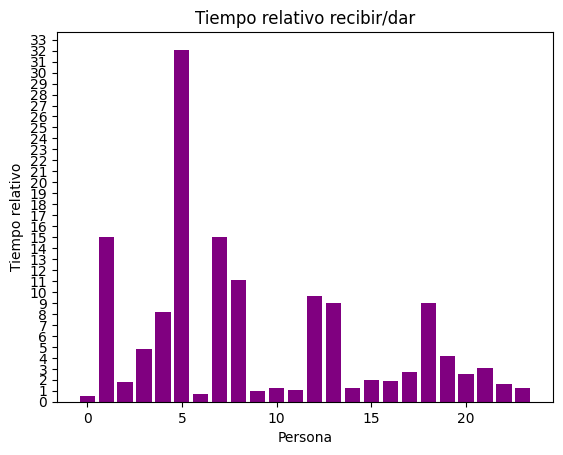

In [ ]:
indices = np.arange(len(r))
plt.bar(indices, r, color='purple')
plt.title('Tiempo relativo recibir/dar')
plt.xlabel('Persona')
plt.ylabel('Tiempo relativo')
plt.yticks(np.arange(0, max(r)+1, 1))

([<matplotlib.axis.YTick at 0x7efc16cffd30>,
 [Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4'),
  Text(0, 5.0, '5'),
  Text(0, 6.0, '6'),
  Text(0, 7.0, '7'),
  Text(0, 8.0, '8'),
  Text(0, 9.0, '9'),
  Text(0, 10.0, '10'),
  Text(0, 11.0, '11'),
  Text(0, 12.0, '12'),
  Text(0, 13.0, '13'),
  Text(0, 14.0, '14'),
  Text(0, 15.0, '15'),
  Text(0, 16.0, '16'),
  Text(0, 17.0, '17'),
  Text(0, 18.0, '18'),
  Text(0, 19.0, '19'),
  Text(0, 20.0, '20'),
  Text(0, 21.0, '21'),
  Text(0, 22.0, '22'),
  Text(0, 23.0, '23'),
  Text(0, 24.0, '24'),
  Text(0, 25.0, '25'),
  Text(0, 26.0, '26'),
  Text(0, 27.0, '27'),
  Text(0, 28.0, '28'),
  Text(0, 29.0, '29'),
  Text(0, 30.0, '30'),
  Text(0, 31.0, '31'),
  Text(0, 32.0, '32'),
  Text(0, 33.0, '33')])

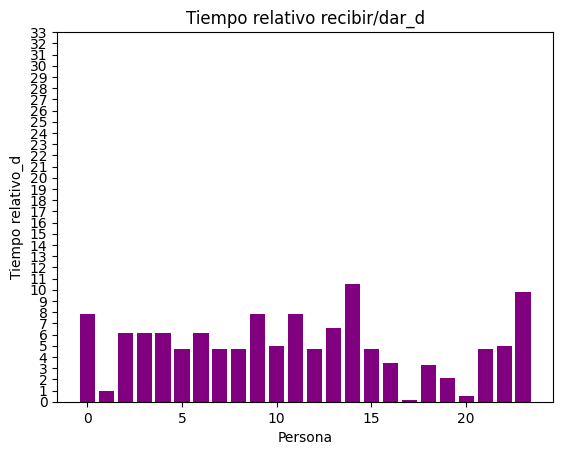

In [ ]:
indices = np.arange(len(rd))
plt.bar(indices, rd, color='purple')
plt.title('Tiempo relativo recibir/dar_d')
plt.xlabel('Persona')
plt.ylabel('Tiempo relativo_d')
plt.yticks(np.arange(0, max(r)+1, 1))

In [ ]:
tpr=sum(r)/len(r)
tpr

5.856518037492905

In [ ]:
tprd=sum(rd)/len(rd)
tprd

5.150468996410367

In [ ]:
R=np.array(r)
comparativa = np.vstack((T, R))
df=pd.DataFrame(comparativa)
df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,8.000000,42.000000,21.000000,50.000000,33.0,18.000000,19.000000,44.000000,28.000000,18.000000,...,1.000000,20.000000,23.000,23.000000,32.000000,4.000000,14.000000,15.000000,32.000000,28.000000
1,0.526316,15.033333,1.793939,4.848485,8.2,32.086957,0.675676,15.033333,11.111111,0.972973,...,1.212121,2.018182,1.875,2.671875,8.965517,4.193548,2.533333,3.058824,1.636364,1.233333


In [ ]:
Rd=np.array(rd)
comparativad = np.vstack((T, Rd))
dfd=pd.DataFrame(comparativad)
dfd

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,8.000,42.0,21.000000,50.000000,33.000000,18.000000,19.000000,44.000000,28.000000,18.000,...,1.0,20.000000,23.0,23.000000,32.000000,4.0,14.00000,15.000000,32.000000,28.0
1,7.875,1.0,6.176471,6.176471,6.176471,4.666667,6.176471,4.666667,4.666667,7.875,...,10.5,4.666667,3.5,0.143541,3.315789,2.1,0.47619,4.666667,4.941176,9.8


Text(0, 0.5, 'Riqueza (verde)/Espera relativa (azul)')

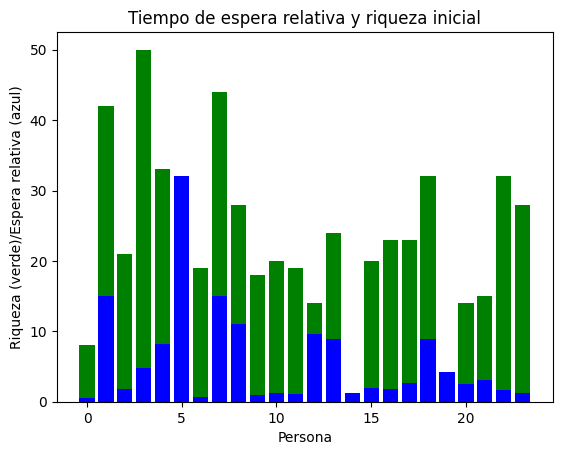

In [ ]:
indices = np.arange(len(T))
plt.bar(indices, T, color='green')
plt.bar(indices, R, color='blue')
plt.title('Tiempo de espera relativa y riqueza inicial')
plt.xlabel('Persona')
plt.ylabel('Riqueza (verde)/Espera relativa (azul)')

Text(0, 0.5, 'Riqueza (verde)/Espera relativa_d (azul)')

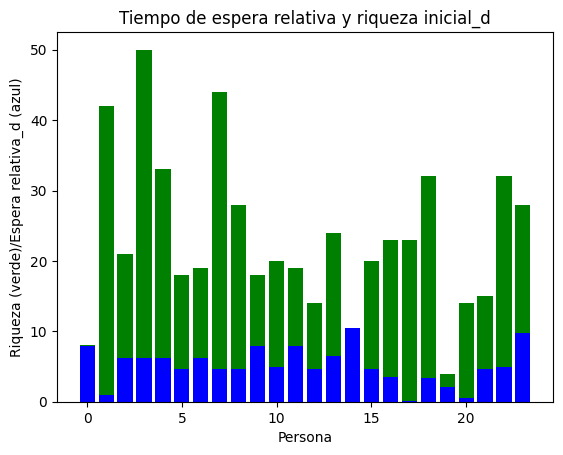

In [ ]:
indices = np.arange(len(T))
plt.bar(indices, T, color='green')
plt.bar(indices, Rd, color='blue')
plt.title('Tiempo de espera relativa y riqueza inicial_d')
plt.xlabel('Persona')
plt.ylabel('Riqueza (verde)/Espera relativa_d (azul)')

# Loop para la generación de matrices de capacidad de trueque y tiempos promedio

In [ ]:
Tp=[]
Tp2=[]
for step in range(25):
  CTi=np.random.randint(1, 51, size=24)
  CT=tru_mut(CTi)[1]
  Var=tru_mut(CTi)[0]
  iopt=np.argmin(Var)
  ct=CT[:iopt]
  ctcont=[]
  for _ in range(iopt-1):
    ctcont.append(ct[_+1]-ct[_])
    mct=np.array(ctcont)
  Tp.append(contar(mct)[1])
  Tp2.append(contar2(mct)[1])


In [ ]:
Tpd=[]
Tp2d=[]
for step in range(25):
  CTid=np.random.randint(1, 51, size=24)
  CTd=tru_mutd(CTid)[1]
  Vard=tru_mutd(CTid)[0]
  ioptd=np.argmin(Vard)
  ctd=CTd[:ioptd]
  ctcontd=[]
  ioptd=np.argmin(Vard)
  for _ in range(ioptd-1):
    ctcontd.append(ctd[_+1]-ctd[_])
    mctd=np.array(ctcontd)
  Tpd.append(contar(mctd)[1])
  Tp2d.append(contar2(mctd)[1])

In [ ]:
Tp

[9.120162938912943,
 11.464765211640213,
 10.51412805692697,
 15.046955026182966,
 10.238277925777926,
 11.707142857142857,
 12.51799543049543,
 10.296406371406372,
 12.467608780108778,
 11.003769841269843,
 11.939897486772487,
 11.737797619047617,
 12.287427101049394,
 11.078090438292643,
 10.860314454064453,
 10.531679533701594,
 11.852015393375689,
 11.892129629629624,
 15.774537972240177,
 11.37729353979354,
 8.97188852813853,
 12.989280497552555,
 9.861457061457061,
 9.113627601006664,
 13.673455452499573]

In [ ]:
Tpd

[31.136116198616197,
 11.825000000000001,
 18.686843885281387,
 30.12663372507122,
 30.12663372507122,
 15.748263888888891,
 15.748263888888891,
 20.384627525252526,
 4.5625,
 4.5625,
 2.638888888888889,
 29.470670995670996,
 20.066512422762422,
 28.111888227513223,
 21.47126924001924,
 13.013756613756614,
 21.55727952602953,
 32.32165404040404,
 31.836948273461434,
 10.754166666666668,
 10.754166666666668,
 10.754166666666668,
 20.100836778961778,
 11.619791666666666,
 8.954166666666667]

In [ ]:
Prmre=sum(Tp)/len(Tp)
Prmre

11.532724189939438

In [ ]:
Prmred=sum(Tpd)/len(Tpd)
Prmred

18.25334184711487

In [ ]:
Tp2

[4.581141665352193,
 5.014281946267238,
 4.54030646300867,
 5.498243552471494,
 5.293881805830335,
 4.940844456469456,
 4.409255443630443,
 4.416826875466581,
 5.064869736744736,
 4.505226370851371,
 5.072210197210197,
 4.579506257631257,
 4.868266903713002,
 4.80581345057448,
 4.591735347985346,
 5.027945781070781,
 4.901257796089958,
 5.383456589706591,
 4.64311141580298,
 4.8172834110334115,
 4.292923280423281,
 4.8376521219055535,
 5.0469937469937465,
 4.946281537084395,
 4.61930193344667]

In [ ]:
Tp2d

[7.345478595478596,
 5.864583333333332,
 5.3715909090909095,
 6.337970594220594,
 6.337970594220594,
 6.2214285714285715,
 6.2214285714285715,
 6.645171957671956,
 3.215277777777778,
 3.215277777777778,
 2.430555555555556,
 5.80737376049876,
 5.728082912457913,
 5.769849057532881,
 4.9425159331409345,
 6.170238095238094,
 6.398660714285715,
 6.246834660437602,
 5.547254597254597,
 5.690277777777777,
 5.690277777777777,
 5.690277777777777,
 7.085152116402118,
 5.495138888888889,
 5.052777777777778]

In [ ]:
Prdar=sum(Tp2)/len(Tp2)
Prdar

4.827944723470567

In [ ]:
Prdard=sum(Tp2d)/len(Tp2d)
Prdard

5.620857843409314

In [ ]:
Espera_rel=Prmre/Prdar
Espera_rel

2.3887440413048355

In [ ]:
Espera_reld=Prmred/Prdard
Espera_reld

3.247429904052397